In [1]:
import numpy as np
from simulation.generate_path import generate_path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from estimation.distance_sensor import distance_sensors
from estimation.iterative_estimator import iterative_estimator
from estimation.kalman_filter_from_points import kalman_filter_from_points
from estimation.kalman_filter_from_points_with_acc import kalman_filter_from_points_acc
from estimation.improved_kalman_filter_from_points_with_acc import improved_kalman_filter_from_points_acc
from estimation.KF_with_mahalanobis_threshold import kalman_filter_with_mahalanobis

# For making the plots interactive, uncomment next line:
# %matplotlib widget

/home/user/miniconda3/envs/cuda_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# print the seed used
seed = np.random.randint(0, 100000)
print(seed)
np.random.seed(seed)

89467


In [3]:
# create the path

target_initial_pos = np.array([0, 0, 5000])
target_speed_xy = 50
target_speed_z = 10
target_rot_speed = 3
time_res = 0.1
sensor_sigma = 15

path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
path1.add_straight_interval(100)
path1.add_xy_turn_interval(90, -np.deg2rad(target_rot_speed))
path1.add_straight_interval(100)

outliers = np.random.randint(0, len(path1.path[:,0]), size=len(path1.path))
outliers = outliers > (100 - 2)

In [4]:
# create noisy sensors
sensors = distance_sensors([[-5000,0,0], [400, -7400, 0], [800, 800, 0]], sensor_sigma)
sensors.calculate_measurements(path1.path)

sensors_noisy = distance_sensors([[-5000,0,0],[ 400, -7400, 0],[800, 800, 0]], 200)
sensors_noisy.calculate_measurements(path1.path)

In [5]:
# estimate the path
it_est = iterative_estimator(sensors, path1.path[0,:])
estimated_path = it_est.estimate_path()
cov_mat_it = it_est.get_cov_err_with_sigma(estimated_path, sigma=15)

it_est_noisy = iterative_estimator(sensors_noisy, path1.path[0,:])
estimated_path_noisy = it_est_noisy.estimate_path()


In [6]:
# create path with outliers
for i in np.arange(len(outliers)):
    if outliers[i]:    
        estimated_path_noisy[i,:] = estimated_path[i,:]

In [7]:
# run KF on path
sigma_a = 1
sigma_v = 100

improved_KF = improved_kalman_filter_from_points_acc(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2)
kf_acc = kalman_filter_from_points_acc(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2)
kf_mahal = kalman_filter_with_mahalanobis(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2)

kf_path_acc = kf_acc.filter_path(estimated_path_noisy)
kf_path_improved = improved_KF.filter_path(estimated_path_noisy, cov=cov_mat_it)
kf_path_mahal, mahal_skipped_samples, mahalanobis_dists = kf_mahal.filter_path(estimated_path_noisy, cov=cov_mat_it)

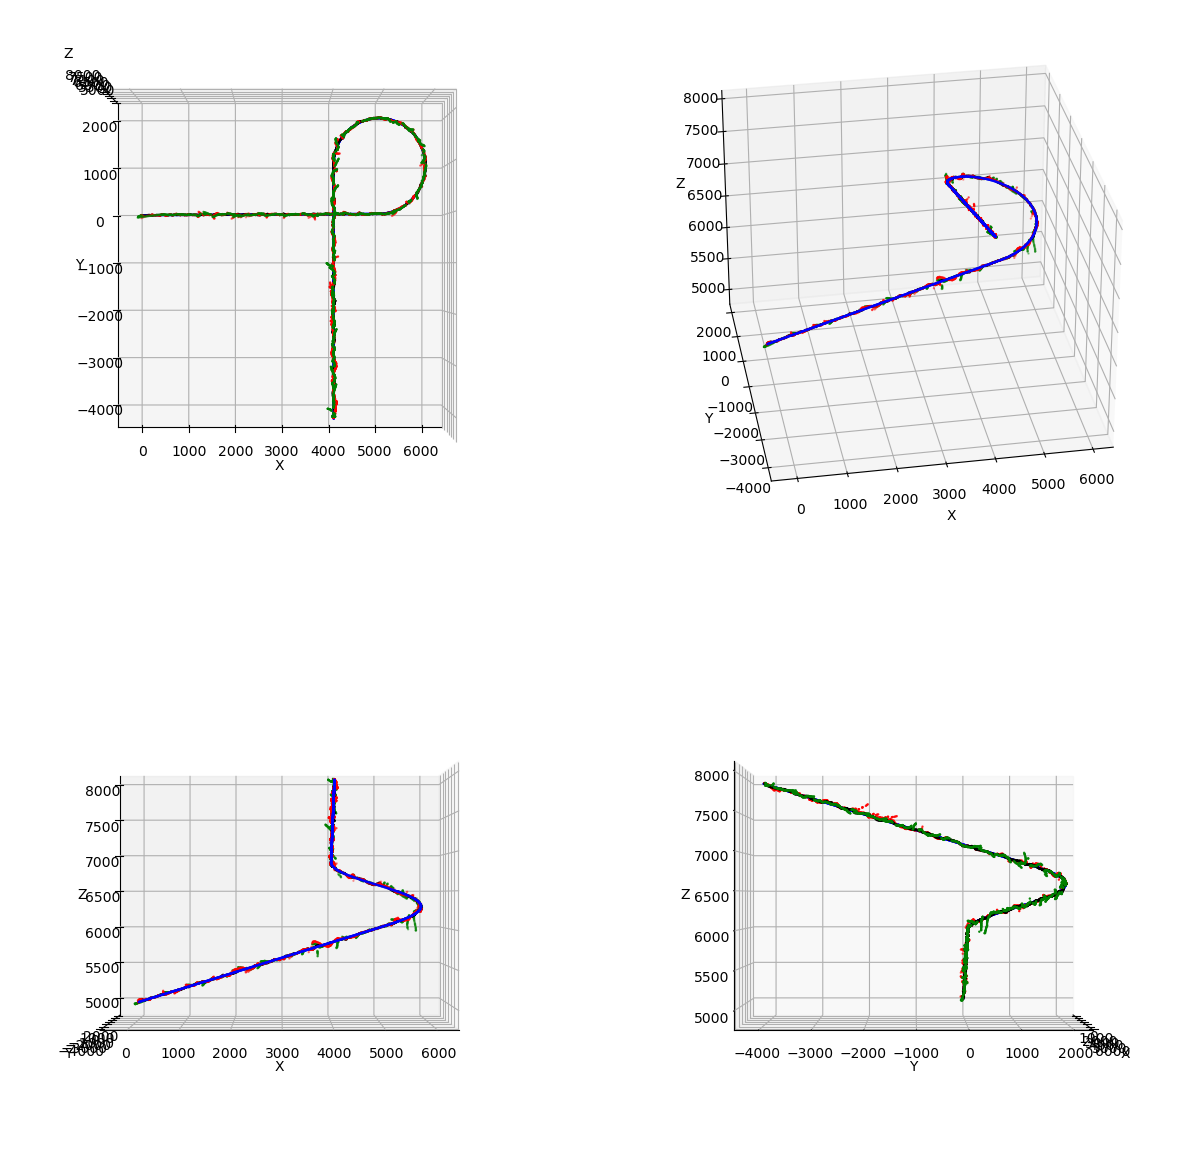

In [8]:
# Plot the path vs KF path
fig = plt.figure(figsize = (15, 15))
axes = []
views = [(90, -90), (30, -100), (0, -90), (0, 0)]
for i, view in enumerate(views):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.scatter(path1.path[:, 0], path1.path[:, 1], path1.path[:, 2], color='blue', s=0.5)
    #ax.scatter(estimated_path_noisy[:, 0], estimated_path_noisy[:, 1], estimated_path_noisy[:, 2], color='red', s=0.5)
    ax.scatter(kf_path_improved[:, 0], kf_path_improved[:, 1], kf_path_improved[:, 2], color='red', s=0.5)
    ax.scatter(kf_path_acc[:, 0], kf_path_acc[:, 1], kf_path_acc[:, 2], color='g', s=0.5)
    ax.scatter(kf_path_mahal[:, 0], kf_path_mahal[:, 1], kf_path_mahal[:, 2], color='k', s=0.5)
    ax.view_init(elev=view[0], azim=view[1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

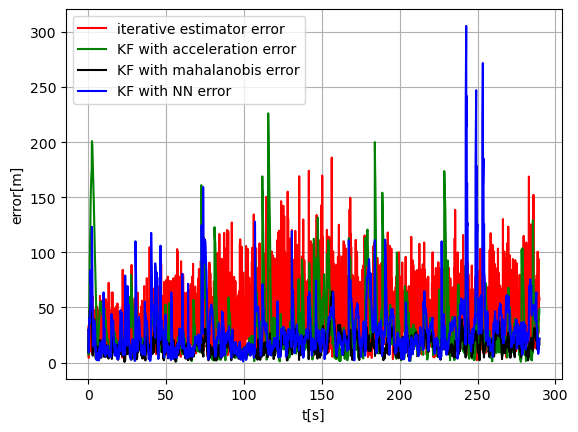

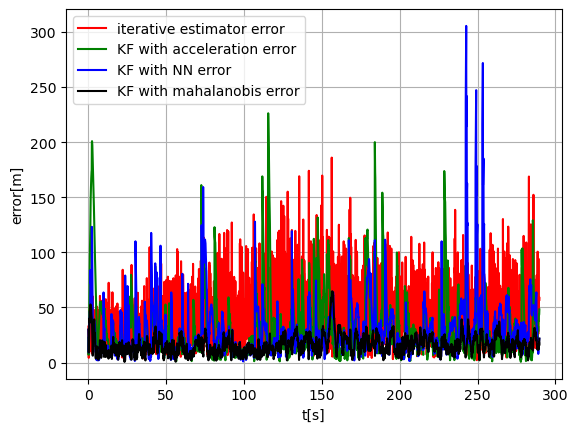

In [9]:
# show error of KF vs no KF
it_est_MSE = np.sqrt(np.sum(np.square(estimated_path-path1.path), 1))
kf_acc_MSE = np.sqrt(np.sum(np.square(kf_path_acc-path1.path), 1))
improved_kf_acc_MSE = np.sqrt(np.sum(np.square(kf_path_improved-path1.path), 1))
kf_mahal_MSE = np.sqrt(np.sum(np.square(kf_path_mahal-path1.path), 1))
t = path1.time

plt.figure()
plt.plot(t, it_est_MSE, label=f'iterative estimator error', color='r')
plt.plot(t, kf_acc_MSE, label=f'KF with acceleration error', color='g')
plt.plot(t, kf_mahal_MSE, label=f'KF with mahalanobis error', color='k')
plt.plot(t, improved_kf_acc_MSE, label=f'KF with NN error', color='b')

plt.xlabel('t[s]')
plt.ylabel('error[m]')
plt.grid()
plt.legend()
plt.show()



plt.figure()
plt.plot(t, it_est_MSE, label=f'iterative estimator error', color='r')
plt.plot(t, kf_acc_MSE, label=f'KF with acceleration error', color='g')
plt.plot(t, improved_kf_acc_MSE, label=f'KF with NN error', color='b')
plt.plot(t, kf_mahal_MSE, label=f'KF with mahalanobis error', color='k')

plt.xlabel('t[s]')
plt.ylabel('error[m]')
plt.grid()
plt.legend()
plt.show()

Text(0, 0.5, 'mean error[m]')

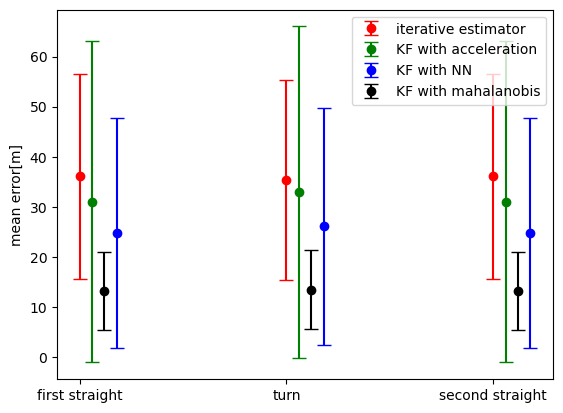

In [10]:
section_lengths = (np.array([100, 90, 100]) * (1/time_res)).astype(int)


iterative_means = np.empty(len(section_lengths))
iterative_std = np.empty(len(section_lengths))
kf_acc_means = np.empty(len(section_lengths))
kf_acc_std = np.empty(len(section_lengths))
kf_mahal_means = np.empty(len(section_lengths))
kf_mahal_std = np.empty(len(section_lengths))
kf_NN_means = np.empty(len(section_lengths))
kf_NN_std = np.empty(len(section_lengths))
x = np.linspace(0,1,section_lengths.shape[0])

current_length = 0
for i, section_length in enumerate(section_lengths):
    next_length = current_length + section_length

    iterative_means[i] = np.mean(it_est_MSE[current_length:next_length])
    iterative_std[i] = np.std(it_est_MSE[current_length:next_length])
    kf_acc_means[i] = np.mean(kf_acc_MSE[current_length:next_length])
    kf_acc_std[i] = np.std(kf_acc_MSE[current_length:next_length])

    kf_mahal_means[i] = np.mean(kf_mahal_MSE[current_length:next_length])
    kf_mahal_std[i] = np.std(kf_mahal_MSE[current_length:next_length])
    kf_NN_means[i] = np.mean(improved_kf_acc_MSE[current_length:next_length])
    kf_NN_std[i] = np.std(improved_kf_acc_MSE[current_length:next_length])

plt.errorbar(x+0.00*3, iterative_means, yerr=iterative_std, linestyle='None', marker='o', color="r", capsize=5, label=f'iterative estimator')
plt.errorbar(x+0.01*3, kf_acc_means, yerr=kf_acc_std, linestyle='None', marker='o', color="g", capsize=5, label=f'KF with acceleration')
plt.errorbar(x+0.03*3, kf_NN_means, yerr=kf_NN_std, linestyle='None', marker='o', color="b", capsize=5, label=f'KF with NN')
plt.errorbar(x+0.02*3, kf_mahal_means, yerr=kf_mahal_std, linestyle='None', marker='o', color="k", capsize=5, label=f'KF with mahalanobis')
plt.xticks(x, ['first straight', 'turn', 'second straight'])#, rotation=90)
plt.legend()
plt.ylabel('mean error[m]')
